In [ ]:
!pip install imbalanced-learn
!pip install category-encoders
!pip install missingpy
!pip install miceforest

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 80 kB 2.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 49 kB 3.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.0 MB/s 
     |████████████████████████████████| 2.0 MB 5.7 MB/s 
     |████████████████████████████████| 2.6 MB 37.4 MB/s 
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 2.2.3
    Uninstalling lightgbm-2.2.3:
      Successfully uninstalled lightgbm-2.2.3


In [ ]:
# https://www.kaggle.com/datasets/arashnic/hr-analytics-job-change-of-data-scientists?datasetId=1019790&sortBy=voteCount
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
%matplotlib inline

# Fit models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
# Scoring functions
from category_encoders import TargetEncoder, LeaveOneOutEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, classification_report
from imblearn.over_sampling import SMOTE
from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score as acc

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/aug_train.csv')
df_train = df_train.drop(columns = ['enrollee_id'])
cate_col = ['city', 'gender', 'relevent_experience', 'enrolled_university', 
      'education_level', 'major_discipline', 'experience','company_size',
      'company_type', 'last_new_job']

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    19158 non-null  object 
 1   city_development_index  19158 non-null  float64
 2   gender                  14650 non-null  object 
 3   relevent_experience     19158 non-null  object 
 4   enrolled_university     18772 non-null  object 
 5   education_level         18698 non-null  object 
 6   major_discipline        16345 non-null  object 
 7   experience              19093 non-null  object 
 8   company_size            13220 non-null  object 
 9   company_type            13018 non-null  object 
 10  last_new_job            18735 non-null  object 
 11  training_hours          19158 non-null  int64  
 12  target                  19158 non-null  float64
dtypes: float64(2), int64(1), object(10)
memory usage: 1.9+ MB


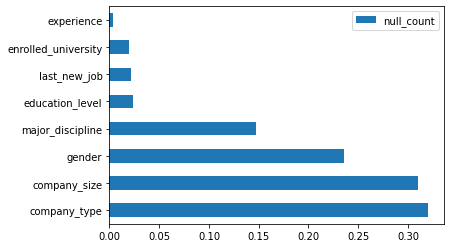

In [ ]:
null_count = df_train.isna().sum()/len(df_train)
null_count = pd.DataFrame(data=null_count[null_count != 0].sort_values(ascending=False),columns=['null_count'])
null_count.plot(kind = "barh")
plt.show()

In [ ]:
#training hours因為是工作時數 可以作正規化
from sklearn import preprocessing
robust = preprocessing.RobustScaler()
df_train['training_hours'] = robust.fit_transform(df_train[['training_hours']])

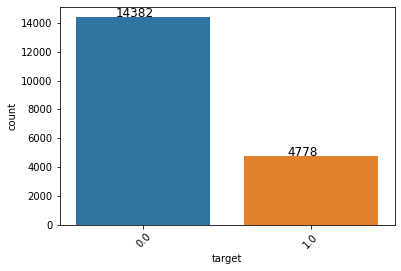

In [ ]:
ax = sns.countplot(x=df_train['target'],data = df_train)
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
for p in ax.patches:
  ax.annotate(format(p.get_height()+1), (p.get_x()+0.35, p.get_height()+10),ha='center',size=12)
# matplotlib version 3.4.1
#for container in ax.containers:
#  ax.bar_label(container)

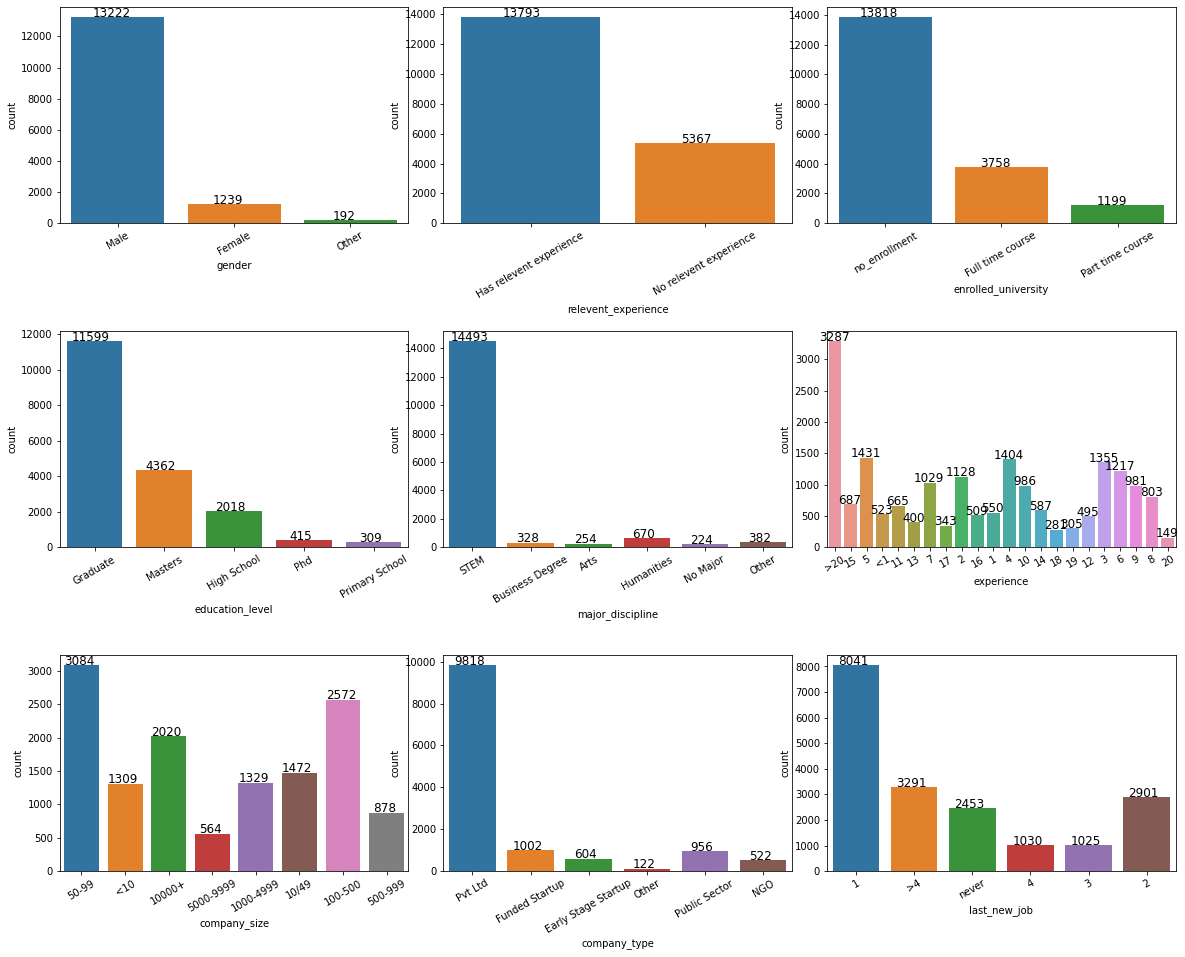

In [ ]:
plt.figure(figsize=(20,15))
for i in range(len(cate_col[1:])):
  plt.subplot(3,3,i+1)
  ax = sns.countplot(x=cate_col[i+1],data = df_train)
  ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
  for p in ax.patches:
    ax.annotate(format(p.get_height()+1), (p.get_x()+0.35, p.get_height()+10),ha='center',size=12)
plt.subplots_adjust(left=0.125,
          bottom=0.1, 
          right=0.9, 
          top=0.9, 
          wspace=0.1, 
          hspace=0.5)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


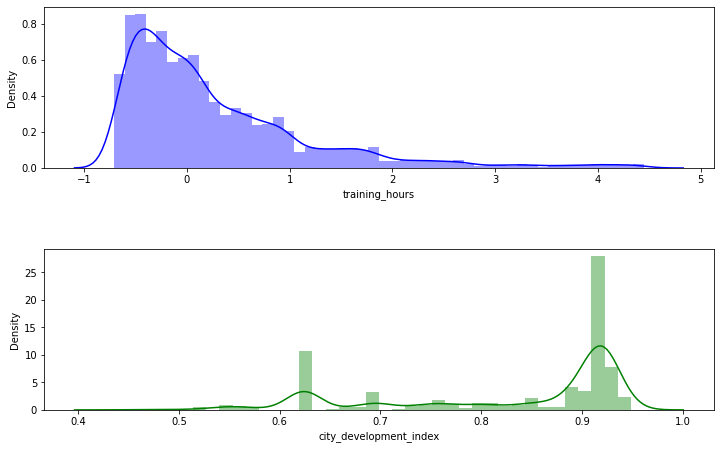

In [ ]:
plt.figure(figsize=(12,7))
plt.subplot(2,1,1)
sns.distplot(df_train["training_hours"], color="blue")
plt.subplot(2,1,2)
sns.distplot(df_train["city_development_index"], color="green")
plt.subplots_adjust(bottom=0.1, top=0.9, wspace=0.1, hspace=0.5)  

In [ ]:
dict_education_level = {value : key for key,value in enumerate(df_train.education_level.value_counts().index)}
dict_major_discipline = {value : key for key,value in enumerate(df_train.major_discipline.value_counts().index)}
dict_experience = {value : key for key,value in enumerate(df_train.experience.value_counts().index)}
dict_company_size = {value : key for key,value in enumerate(df_train.company_size.value_counts().index)}
dict_company_type = {value : key for key,value in enumerate(df_train.company_type.value_counts().index)}
dict_company_last_new_job = {value : key for key,value in enumerate(df_train.last_new_job.value_counts().index)}
#categoricalconvert into numeric label
df_train['gender'] = df_train['gender'].map({'Male':0,'Female':1,'Other':2})
df_train['enrolled_university'] = df_train['enrolled_university'].map({'no_enrollment':0,'Full time course':1,'Part time course':2})
df_train['education_level'] = df_train['education_level'].map(dict_education_level)
df_train['major_discipline'] = df_train['major_discipline'].map(dict_major_discipline)
df_train['experience'] = df_train['experience'].map(dict_experience)
df_train['company_size'] = df_train['company_size'].map(dict_company_size)
df_train['company_type'] = df_train['company_type'].map(dict_company_type)
df_train['last_new_job'] = df_train['last_new_job'].map(dict_company_last_new_job)
#city and relevent experience dont have null value --> using label encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_train['city'] = le.fit_transform(df_train['city'])
df_train['relevent_experience'] = le.fit_transform(df_train['relevent_experience'])

In [ ]:
#空值
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
import sys
import sklearn.neighbors._base 
import sys
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest

catecol = ['city','gender','relevent_experience','enrolled_university','education_level',
      'major_discipline','experience','company_size','company_type','last_new_job']

#strategy1 空值補眾數
def fill_median(df):
  imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
  imp = imputer.fit(df)
  dfimpute = imp.transform(df) 
  dfimpute = pd.DataFrame(dfimpute,columns = df.columns)
  dfimpute[catecol] = dfimpute[catecol].astype(int)
  dfimpute['target'] = dfimpute.target.astype(int)
  return dfimpute

#strategy2 KNNimputer 
def knnimputer(df):
  impute = KNNImputer(n_neighbors = 3) #KNN imputation
  dfimpute = np.round(impute.fit_transform(df))
  dfimpute = pd.DataFrame(dfimpute, columns = df.columns).round(1)
  dfimpute[catecol] = dfimpute[catecol].astype(int)
  dfimpute['target'] = dfimpute.target.astype(int)
  return dfimpute

def missforest(df):
  imputer = MissForest() #miss forest
  dfimpute = np.round(imputer.fit_transform(df))
  dfimpute = pd.DataFrame(dfimpute, columns = df.columns).round(1)
  dfimpute[catecol] = dfimpute[catecol].astype(int)
  dfimpute['target'] = dfimpute.target.astype(int)
  return dfimpute

df_median = fill_median(df_train)
df_knn = knnimputer(df_train)
df_missforest = missforest(df_train)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: 

Iteration: 0


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: 

Iteration: 1


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: 

Iteration: 2


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: 

Iteration: 3


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: 

Iteration: 4


# feature importance

In [ ]:
def feature_importance(df):
  x = df[df.columns[:-1]]
  y = df['target']
  model = LogisticRegression()
  model.fit(x,y)
  importance = model.coef_[0]
  importance = pd.DataFrame(importance,columns=['target'],index = df_median.columns[:-1])
  return importance

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


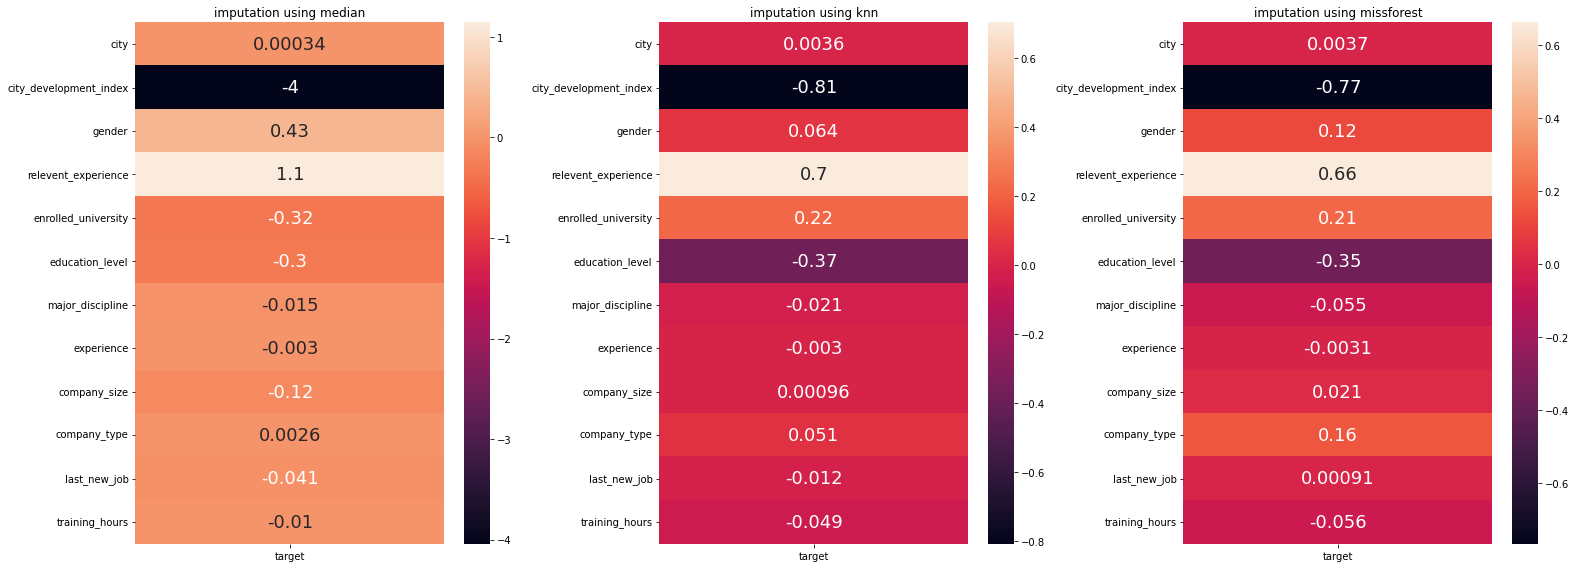

In [ ]:
# Logistic Regression correlation
plt.figure(figsize=(22,8))
plt.subplot(1,3,1)
ax1 = sns.heatmap(feature_importance(df_median),annot=True,annot_kws={"size": 18})
ax1.set_title('imputation using median')
plt.subplot(1,3,2)
ax2 = sns.heatmap(feature_importance(df_knn),annot=True,annot_kws={"size": 18})
ax2.set_title('imputation using knn')
plt.subplot(1,3,3)
ax3 = sns.heatmap(feature_importance(df_missforest),annot=True,annot_kws={"size": 18})
ax3.set_title('imputation using missforest')
plt.tight_layout()
plt.show()

In [ ]:
#target encoding leave one out
def targetencoding(df):
  columns = df.columns[:-2]
  x = df.drop(columns = ['target'])
  y = df['target']
  encoder = LeaveOneOutEncoder(cols=cate_col ,sigma = 0.05)
  df = encoder.fit_transform(x,y)
  df['Class'] = y
  return df

In [ ]:
df_median_encoding = targetencoding(df_median)
df_knn_encoding = targetencoding(df_knn)
df_missforest_encoding = targetencoding(df_missforest)

In [ ]:
#進行train test split
from sklearn.model_selection import train_test_split
X_train_median, X_test_median,Y_train_median, Y_test_median= train_test_split(df_median_encoding.iloc[:,0:12],df_median_encoding['Class'],test_size=0.1, stratify=df_median_encoding['Class'])
X_train_knn, X_test_knn,Y_train_knn, Y_test_knn= train_test_split(df_knn_encoding.iloc[:,0:12],df_knn_encoding['Class'],test_size=0.1, stratify=df_knn_encoding['Class'])
X_train_missforest, X_test_missforest, Y_train_missforest, Y_test_missforest= train_test_split(df_missforest_encoding.iloc[:,0:12],df_missforest_encoding['Class'],test_size=0.1, stratify=df_missforest_encoding['Class'])

In [ ]:
#建立模型


clf_RandomForest = RandomForestClassifier()
clf_NaiveBayes = GaussianNB()
clf_XGBoost = XGBClassifier()

#Radom Forest 餵3種補值方式
clf_RandomForest_median = clf_RandomForest.fit(X_train_median, Y_train_median)
clf_RandomForest_knn = clf_RandomForest.fit(X_train_knn,Y_train_knn)
clf_RandomForest_missforest = clf_RandomForest.fit(X_train_missforest, Y_train_missforest)

#Naive Bayes 餵3種補值方式
clf_NaiveBayes_median = clf_NaiveBayes.fit(X_train_median, Y_train_median)
clf_NaiveBayes_knn = clf_NaiveBayes.fit(X_train_knn,Y_train_knn)
clf_NaiveBayes_missforest = clf_NaiveBayes.fit(X_train_missforest, Y_train_missforest)

#XGBoost 餵3種補值方式
clf_XGBoost_median = clf_XGBoost.fit(X_train_median, Y_train_median)
clf_XGBoost_knn = clf_XGBoost.fit(X_train_knn,Y_train_knn)
clf_XGBoost_missforest = clf_XGBoost.fit(X_train_missforest, Y_train_missforest)

### * 用cross validation (Kfold = 5) 分別對三個補值方法的trainset和三種分類模型(randomforest, naivebayes, xgboost)做預測，整體來看用missforestforest在三種分類模型的預測之下會有比較好的效果

### * 因此在後面的部份我們一慮使用用missforest補值方法的資料集來做比較

👏👏👏👏👏

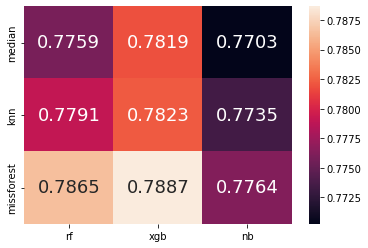

In [ ]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
def get_models():
	models = dict()
	models['rf'] = RandomForestClassifier()
	models['xgb'] = XGBClassifier()
	models['nb'] = GaussianNB()
	return models

def evaluate_model(model,X,Y):
  cv = KFold(n_splits=5, random_state=42, shuffle=True)
  scores = cross_val_score(model, X, Y, scoring='accuracy', cv = cv)
  return scores

def evaluate_testset(model,X_train,Y_train,X_test,Y_test):
  model = model.fit(X_train)
  y_pred = model.predict(X_test)
  acc_score = acc(Y_test,y_pred)
  return acc_score

def show_result(X,Y):
  models = get_models()
  results, names = list(), list()
  for name, model in models.items():
    scores = evaluate_model(model, X, Y)
    results.append(mean(scores))
    names.append(name)
  return results, names

missforest_result, names = show_result(X_train_missforest, Y_train_missforest)
median_result, names = show_result(X_train_median, Y_train_median)
knn_result, names = show_result(X_train_knn, Y_train_knn)
cv_df = pd.DataFrame(data=[median_result,knn_result,missforest_result],columns=names,index = ['median','knn','missforest'])
sns.heatmap(data=cv_df,annot=True,fmt='.4g',annot_kws={"size": 18})

In [ ]:
def evaluate_testset(model,X_train,Y_train,X_test,Y_test):
  model = model.fit(X_train,Y_train)
  y_pred = model.predict(X_test)
  acc_score = acc(Y_test,y_pred)
  return acc_score

testresults = []
models = get_models()
for name, model in models.items():
  scores = evaluate_testset(model, X_train_missforest,Y_train_missforest,X_test_missforest,Y_test_missforest)
  testresults.append(mean(scores))

Text(0.5, 1.0, 'Missforest Test Accuracy Score (no parameter - tuning)')

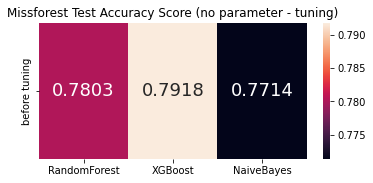

In [ ]:
plt.figure(figsize=(6,2.5))
test_acc_notuned = pd.DataFrame(data=testresults,columns = ['before tuning'],index=["RandomForest","XGBoost","NaiveBayes"]).T
sns.heatmap(data=test_acc_notuned,annot=True,fmt='.4g',annot_kws={"size": 18})
plt.title('Missforest Test Accuracy Score (no parameter - tuning)')

# 因為三種模型都是使用預設的模型參數， 可能沒辦法得到最佳的分數，因此我們透過parameter tuning 中的gridsearchCV 方法來找出每個模型的最佳參數。

# Tune Random Forest Parameter

In [ ]:
rf = RandomForestClassifier()
param_grid = { 
    'n_estimators': [200, 500, 700],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
rf_girdsearch = GridSearchCV(estimator=rf, param_grid=param_grid, cv= 5, scoring='accuracy')
rf_girdsearch.fit(X_train_missforest, Y_train_missforest)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 500, 700]},
             scoring='accuracy')

In [ ]:

#print(f'Random Forest GridSearch Best Parameter : {rf_girdsearch.best_params_}')
rf_best_param = RandomForestClassifier(criterion= 'gini', max_depth= 8, max_features= 'log2', n_estimators= 700)
rf_val_accuracy = evaluate_model(rf_best_param,X_train_missforest,Y_train_missforest)
print(f"validation score : {mean(rf_val_accuracy)}")
rf_best_param.fit(X_train_missforest,Y_train_missforest)
rf_test_acc = acc(Y_test_missforest,rf_best_param.predict(X_test_missforest))
print(f"test score : {rf_test_acc}")

validation score : 0.7863358793261304
test score : 0.7834029227557411


# Tune NaiveBayes Parameter

In [ ]:
nb = GaussianNB()
nb_param_grid = {
    'var_smoothing': np.logspace(0,-9, num=100)
}
nb_girdsearch = GridSearchCV(estimator=nb, param_grid=nb_param_grid, cv= 5, scoring='accuracy')
nb_girdsearch.fit(X_train_missforest, Y_train_missforest)

GridSearchCV(cv=5, estimator=GaussianNB(),
             param_grid={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.51119173e-02, 2.84803587e-02, 2.31...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
             scoring='accuracy')

In [ ]:
print(f'Naive Bayes GridSearch Best Parameter : {nb_girdsearch.best_params_}')
nb_best_param = GaussianNB(**nb_girdsearch.best_params_)
nb_val_accuracy = evaluate_model(nb_best_param,X_train_missforest,Y_train_missforest)
print(f"validation score : {mean(nb_val_accuracy)}")
nb_best_param.fit(X_train_missforest,Y_train_missforest)
nb_test_acc = acc(Y_test_missforest,nb_best_param.predict(X_test_missforest))
print(f"test score : {nb_test_acc}")

Naive Bayes GridSearch Best Parameter : {'var_smoothing': 0.0015199110829529332}
validation score : 0.780071647251061
test score : 0.7771398747390397


# Tune XGBoost Parameter

In [ ]:
xgb = XGBClassifier()
xgb_params_grid = {
        'learning_rate': [0.05, 0.1, 0.20],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5, 6]
        }
xgb_girdsearch = GridSearchCV(estimator=xgb, param_grid=xgb_params_grid, cv= 5, scoring='accuracy')
xgb_girdsearch.fit(X_train_missforest, Y_train_missforest)

GridSearchCV(cv=5, estimator=XGBClassifier(),
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'gamma': [0.5, 1, 1.5, 2, 5],
                         'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [3, 4, 5, 6],
                         'subsample': [0.6, 0.8, 1.0]},
             scoring='accuracy')

In [ ]:
print(f'XGBoost GridSearch Best Parameter : {xgb_girdsearch.best_params_}')
xgb_best_param = XGBClassifier(**xgb_girdsearch.best_params_)
xgb_val_accuracy = evaluate_model(xgb_best_param,X_train_missforest,Y_train_missforest)
print(f'validation score : {mean(xgb_val_accuracy)}')
xgb_best_param.fit(X_train_missforest,Y_train_missforest)
xgb_test_acc = acc(Y_test_missforest,xgb_best_param.predict(X_test_missforest))
print(f"test_score : {xgb_test_acc}")

XGBoost GridSearch Best Parameter : {'colsample_bytree': 1.0, 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 4, 'subsample': 1.0}
validation score : 0.7883073307505655
test_score : 0.7922755741127349


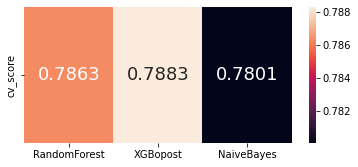

In [ ]:
plt.figure(figsize=(6,2.5))
cv_list = [mean(rf_val_accuracy),mean(xgb_val_accuracy),mean(nb_val_accuracy)]
sns.heatmap(data=pd.DataFrame(data=cv_list,columns=['cv_score'],index=['RandomForest','XGBopost','NaiveBayes']).T,annot=True,fmt='.4g',annot_kws={"size": 18})

Text(0.5, 1.0, 'Compare test accuracy before and after parameter tuning')

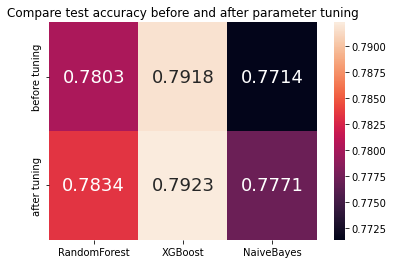

In [ ]:
plt.figure(figsize=(6,4))
cv_list = [mean(rf_test_acc),mean(xgb_test_acc),mean(nb_test_acc)]
test_acc_tuned = pd.DataFrame(data=cv_list,columns=['after tuning'],index=['RandomForest','XGBoost','NaiveBayes']).T
test_set_score = pd.concat([test_acc_notuned,test_acc_tuned])
sns.heatmap(data=test_set_score, annot=True,fmt='.4g',annot_kws={"size": 18})
plt.title("Compare test accuracy before and after parameter tuning")

# Ensemble Method - Voting

In [ ]:
from sklearn.ensemble import VotingClassifier
rf = RandomForestClassifier(criterion= 'gini', max_depth= 8, max_features= 'log2', n_estimators= 700)
nb = GaussianNB(**nb_girdsearch.best_params_)
xgb = XGBClassifier(**xgb_girdsearch.best_params_)
voting_ensemble = VotingClassifier(estimators=[('RandomForest', rf), 
                        ('NaiveBayes', nb),
                        ('XGBoost', xgb)], voting='hard')
voting_ensemble = voting_ensemble.fit(X_train_missforest,Y_train_missforest)
voting_test_acc = acc(Y_test_missforest,voting_ensemble.predict(X_test_missforest))
print(voting_test_acc)

0.7828810020876826


# Ensemble Method - Stacking

In [ ]:
level0 = list()
level0.append(('rf', RandomForestClassifier(**rf_girdsearch.best_params_)))
level0.append(('xgb', XGBClassifier(**xgb_girdsearch.best_params_)))
level0.append(('nb', GaussianNB(**nb_girdsearch.best_params_)))
level1 = LogisticRegression()
stack_model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
stack_model.fit(X_train_missforest,Y_train_missforest)
y_pred = stack_model.predict(X_test_missforest,)
stacking_test_acc = acc(Y_test_missforest,y_pred)
print(f'Stacking accuracy :{acc(Y_test_missforest,y_pred)}')

Stacking accuracy :0.7917536534446764


In [ ]:
test_acc_tuned['Voting'] = voting_test_acc
test_acc_tuned['Stacking'] = stacking_test_acc

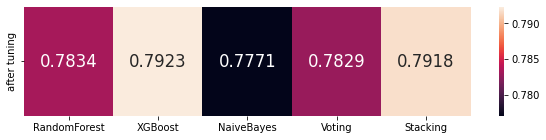

In [ ]:
plt.figure(figsize=(10,2))
sns.heatmap(data = test_acc_tuned, annot=True,fmt='.4g',annot_kws={"size": 16.5})

## confusion matrix

              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1438
           1       0.60      0.51      0.55       478

    accuracy                           0.79      1916
   macro avg       0.72      0.70      0.71      1916
weighted avg       0.78      0.79      0.79      1916



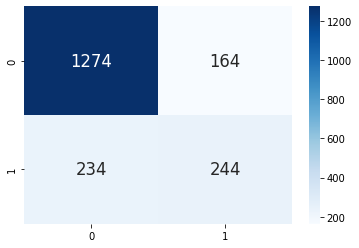

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

xgb_best_param = XGBClassifier(**xgb_girdsearch.best_params_)
xgb_best_param.fit(X_train_missforest,Y_train_missforest)
y_pred_xgb = xgb_best_param.predict(X_test_missforest)
print(classification_report(Y_test_missforest, y_pred_xgb))
cf_matrix = confusion_matrix(Y_test_missforest, y_pred_xgb)
sns.heatmap(cf_matrix, annot=True,fmt='g',annot_kws={"size": 16.5},cmap="Blues")

              precision    recall  f1-score   support

           0       0.81      0.92      0.86      1438
           1       0.59      0.36      0.44       478

    accuracy                           0.78      1916
   macro avg       0.70      0.64      0.65      1916
weighted avg       0.76      0.78      0.76      1916



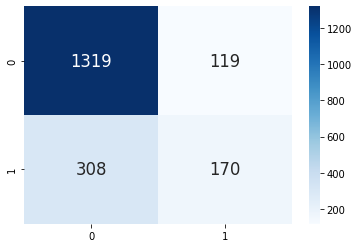

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

nb_best_param = GaussianNB(**nb_girdsearch.best_params_)
nb_best_param.fit(X_train_missforest,Y_train_missforest)
y_pred_nb = nb_best_param.predict(X_test_missforest)
print(classification_report(Y_test_missforest, y_pred_nb))
cf_matrix = confusion_matrix(Y_test_missforest, y_pred_nb)
sns.heatmap(cf_matrix, annot=True,fmt='g',annot_kws={"size": 16.5},cmap="Blues")

              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1438
           1       0.59      0.43      0.50       478

    accuracy                           0.78      1916
   macro avg       0.71      0.67      0.68      1916
weighted avg       0.77      0.78      0.77      1916



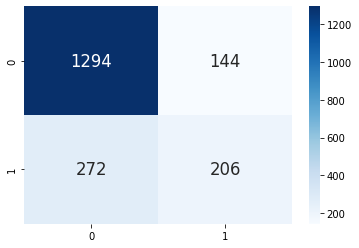

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

rf_best_param = RandomForestClassifier(criterion= 'gini', max_depth= 8, max_features= 'log2', n_estimators= 700)
rf_best_param.fit(X_train_missforest,Y_train_missforest)
y_pred_rf = rf_best_param.predict(X_test_missforest)
print(classification_report(Y_test_missforest, y_pred_rf))
cf_matrix = confusion_matrix(Y_test_missforest, y_pred_rf)
sns.heatmap(cf_matrix, annot=True,fmt='g',annot_kws={"size": 16.5},cmap="Blues")

In [ ]:
pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. U

Text(0.5, 1.0, 'ROC AUC curve')

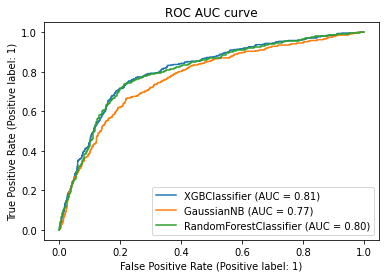

In [ ]:
from sklearn.metrics import plot_roc_curve
fig = plot_roc_curve(xgb_best_param,X_test_missforest,Y_test_missforest)
plot_roc_curve(nb_best_param,X_test_missforest,Y_test_missforest,ax=fig.ax_)
plot_roc_curve(rf_best_param,X_test_missforest,Y_test_missforest,ax=fig.ax_)
plt.title("ROC AUC curve")

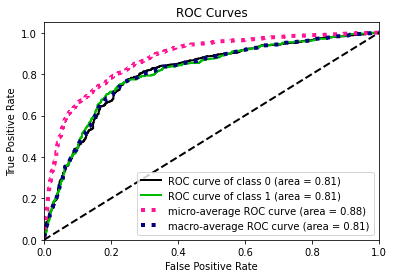

In [ ]:
import scikitplot as skplt

y_proba_xgb = xgb_best_param.predict_proba(X_test_missforest)
skplt.metrics.plot_roc(Y_test_missforest, y_proba_xgb)
plt.show()

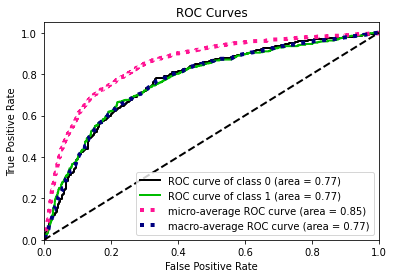

In [ ]:
y_proba_nb = nb_best_param.predict_proba(X_test_missforest)
skplt.metrics.plot_roc(Y_test_missforest, y_proba_nb)
plt.show()

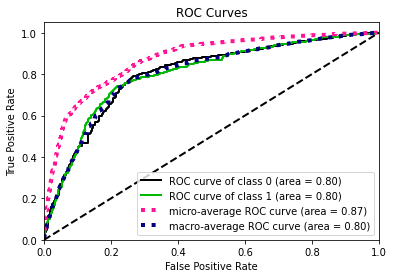

In [ ]:
y_proba_rf = rf_best_param.predict_proba(X_test_missforest)
skplt.metrics.plot_roc(Y_test_missforest, y_proba_rf)
plt.show()